# Social Computing/Social Gaming - Summer 2023
# Exercise Sheet 4 - Social Tie Strength

In this exercise, you are going to predict Tie Strength in a social network using the method explained in the paper _E. Gilbert and K. Karahalios: Predicting Tie Strength With Social Media_ [1], of which a short introduction is provided to you in the exercise files. According to Mark Granovetter, the strength of a tie between two persons is a combination of the amount of time, the emotional intensity, the intimacy and the reciprocal services which characterize it. Using variables that describe these categories, we want to find out how much each one of these features contributes in order to predict the strength of ties not previously known.<br>
An important prerequisite to this exercise is understanding the basic concept of linear regression models. As mentioned in the lecture, a recommended reading is chapter 3 of _C. Bishop: Pattern Recognition and Machine Learning_ [2], which you can find on [Moodle](https://www.moodle.tum.de/) [3].


### Tie Strength Prediction

In social network analysis, the Tie Strength between two people measures how strong their relationship is. The paper above describes the procedure of deriving available information (different variables) about a connection between two persons from an online social network and using it in order to discover how close they are. The ultimate goal is to build a model using the given information, finding out which variables account most for the Tie Strength and using that model later on to predict social Tie Strength when only the predictive (or explanatory) variables are available. Before being able to predict anything, we need to find out whether the given variables are suitable for prediction in the first place. This can be done via creating and evaluating a **multiple linear regression model**. 'Multiple' here refers to having more than one predictive variable in an regression model.<br>
In the paper mentioned above, 67 variables where used in the linear model to predict the Tie Strength. In our simplified model, we are going to use only 10 predictive variables which are:
* number of friends
* number of friends's friends
* days since last communication
* shared appearances in photos
* wall intimacy words
* inbox intimacy words
* days since first communication
* number of mutual friends

We are going to use a simplified form of the paper's linear model:
$$y_i = \alpha + \beta X_i + \epsilon_i$$

where $y_i$ is the dependent variable (also referred to as target value, which is the Tie Strength in our case) of the $i$-th friend of a person. $X_i$ is the predictive vector, containing the (predictive) variables listed above. $\alpha$ and $\beta$ are the model's parameters, where $\alpha$ is the intercept/bias, $\beta$ the coefficient vector containing coefficients for each predictive variable, and $\epsilon$ the prediction error. The regression problem boils down to calculating the model's parameters given a certain ground truth; meaning that for some connections, the Tie Strength has to be already known for building the model. That way, the unknown Tie Strengths can be predicted using the regression model by simply inserting the values into the vector. The coefficients for each predictive variable will show us the importance of the respective variable for the social Tie Strength.

### Problem Overview

The input to your Python program is a directed social network _SocialGraph.gml_. As the first step, you will visualize the graph with NetworkX to get an overview over the data.

In practice, the ground truth (Tie Strength in our case) is usually retrieved by participant's answers to surveys on how strong their relationship is with another person - this is why the graph is directed: two people might have varying views. The ground truth is available in the file. About 70% of the edges have valid values for the `tieStrength` variable, which should be used for training. For about 30% of the edges, the variable is set to -1 (equivalent to unknown). These represent the prediction set for which the Tie Strength should be predicted using the linear regression model later. But first, that model needs to be computed and checked for its goodness of fit.

## Task 4.1: Preparations

### a) Imports and Visualization
First, needed libraries and the graph's .gml file have to be imported. The social graph is visualized in order to get an idea what the network actually looks like.
Inspect the plotted graph. **Describe** shortly, what the graph's visualization is telling you, and if there are any problems with this representation. **Any ideas** on how to improve the visualization?

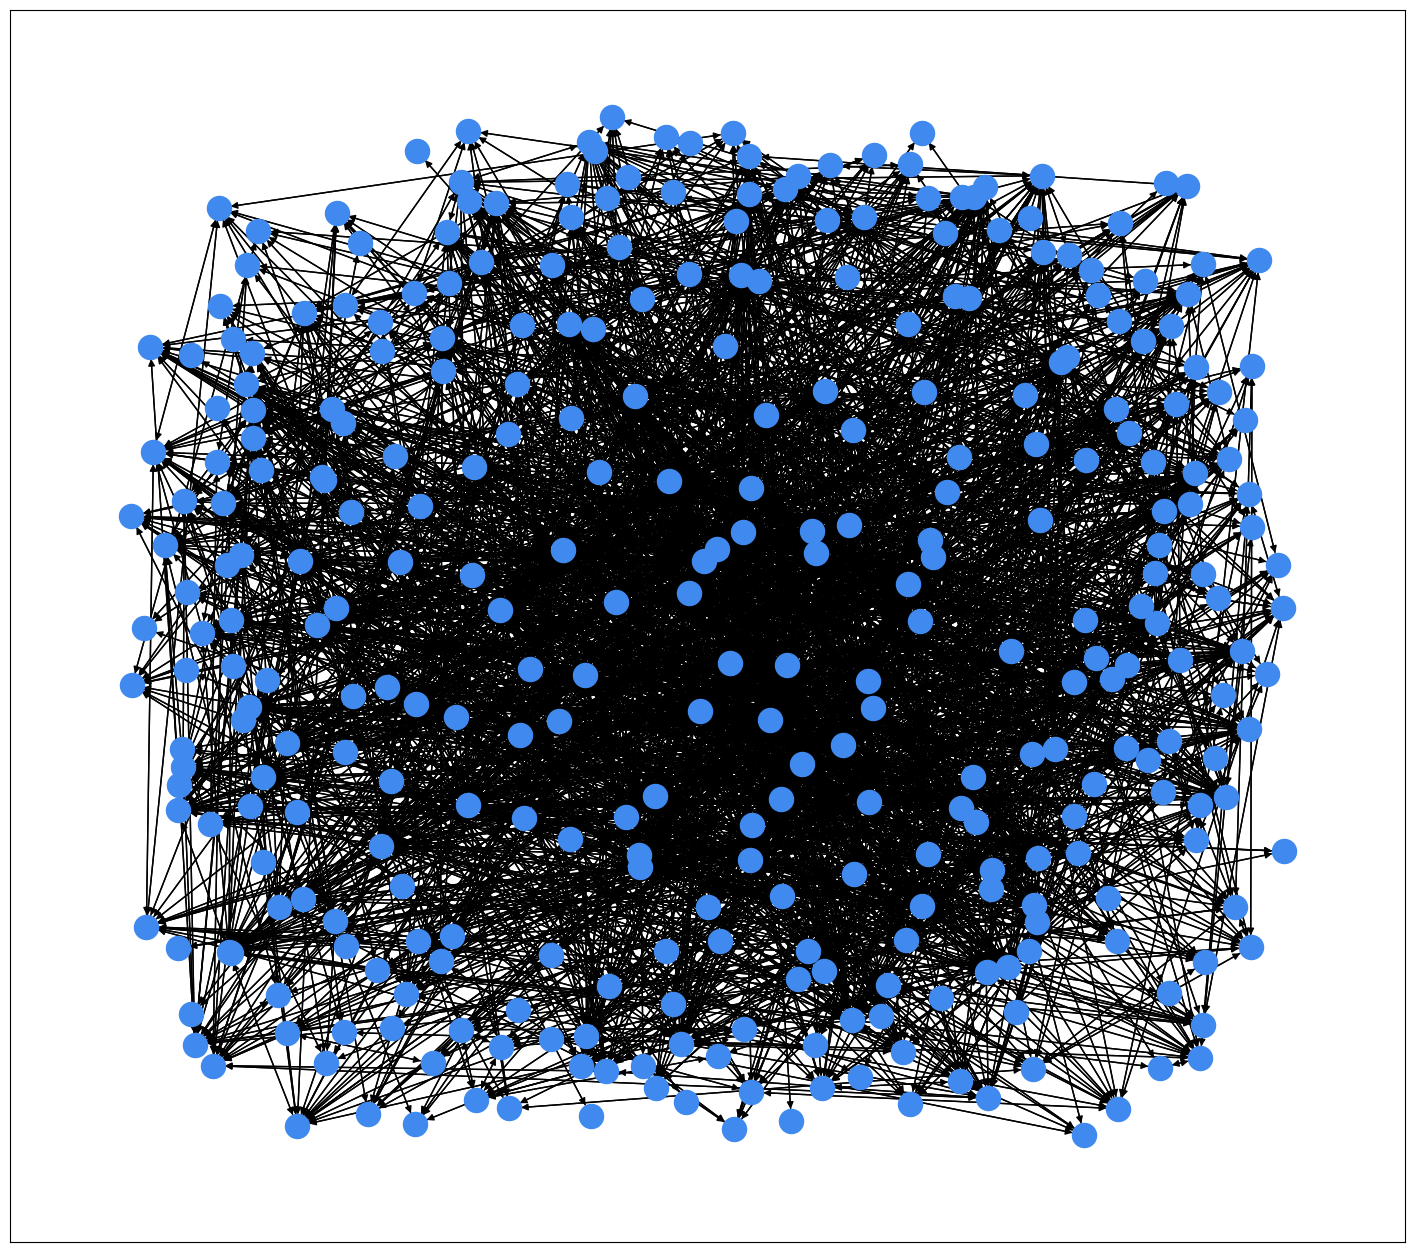

In [5]:
import networkx as nx, numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt

# read in the structure
g = nx.read_gml('SocialGraph.gml', label='id')


# formatting the graph and applying spring layout
fig=plt.figure(figsize=(18, 16))

pos=nx.spring_layout(g, k=0.4, iterations=5)

visual_style = {
    "node_size": 300,
    "node_color": "#4089EF",
    "bbox" : (700,700), 
    "with_labels" : False
}

nx.draw_networkx(g, pos, **visual_style)

**TODO: Write your observations and ideas here**

### b) Complete and convert the data

To further work with our data set, we will now convert it to a [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) [4] dataframe. 
Some of our predictive variables are not yet computed in the _gml_ file, therefore you have to **calculate the missing variables** from the graph's attributes. You can take a look at the _gml_ file as it is human-readable to see what variables are available for you.

In [ ]:
# Calculates the missing values for current edge e of graph g
def calculate_missing_variables(g, e):
    # The both nodes connected by edge e
    first, second = e
    # Edge data such as firstComm and tieStrength
    edge_data = g.get_edge_data(first, second)
    
    # Source and target nodes for current edge
    src = g.nodes[first]
    tgt = g.nodes[second]
        
    # Already existing variables
    days_last_comm = edge_data['lastComm']
    photos_together = edge_data['photosTogether']
    wall_intim_words = edge_data['wallIntimWords']
    inbox_intim_words = edge_data['inboxIntimWords']
    days_first_comm = edge_data['firstComm']
    
    # The Ground Truth
    tie_strength = edge_data['tieStrength']

    # TODO: Compute the missing values
    age_dist = #TODO
    edu_diff = #TODO
    num_friends = #TODO
    friends_num_friends = #TODO
    num_mutual_friends = #TODO

    
    # Create row for dataframe
    row = [num_friends, friends_num_friends, days_last_comm, photos_together, wall_intim_words, inbox_intim_words, days_first_comm, num_mutual_friends, age_dist, edu_diff]
    row = [int(attr) for attr in row]
    row.append(tie_strength) # Appended separately, needs to be float
    
    return row



#TODO: modify the code to correctly split the data
# Training and prediction lists
train_list = []
pred_list = []
cols = ['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff', 'Tie Strength']

# Calculate rows (one for each edge) and add them to tables

for e in g.edges:
    row = calculate_missing_variables(g, e)
    
    first, second = e
    edge = g.get_edge_data(first, second)
    
    if edge['tieStrength'] != -1:
        train_list.append(row)
    else:
        pred_list.append(row)
        
# Create training and prediction tables
train_table = pd.DataFrame(train_list, columns=cols)
pred_table = pd.DataFrame(pred_list, columns=cols)
train_table.head(10)

### c) The Variance Inflation Factor (VIF)
Multiple linear regression can hold some pitfalls if you do not evaluate your data beforehands. Such a pitfall is containing multicollinearity in your predictive variables. 

Find out and **explain** in your own words what multicollinearity is, why it forms a danger to linear regression models and how the VIF is linked to that. 
**Create** a temporary dataframe containing only the predictive variables and **add a constant value** to the dataframe for the VIF to produce representative values. Then **compute the VIFs** for them. Statsmodels `variance_inflation_factor()` and `add_constant()` will help you with that. 

Additionally **explain**: What do the results tell you? Do we have to make any adaptions deriving from them?

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant


# TODO: Creat a dataframe, add a constant & compute VIF



**TODO: Write your explanaitions here**

### d) Normalisation-Transformation

Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalisation is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. Not every dataset does require normalization, however as our dataset has variables with different ranges we need to normalize it.

With the help of sklearn's preprocessing functionality,  **apply the normalisation-transformation on each feature vector for the training table (but not the Tie Strength)**. You can find more information about the preprocessing functionality [here](https://scikit-learn.org/stable/modules/preprocessing.html). [5] Again, output the first ten entries of your dataframe.

In [ ]:
# TODO: Apply normalization transformation



## Task 4.2: The Regression Model

### a) Building the model
**1.**
Finally, the regression can be applied on the dataframe. For this purpose, **split** the dataframe into `y`: the target variable and `X`: the predictive variables. As you have read above, our model contains a bias/intercept named $\alpha$. This will be realized in the model by adding a constant (1.0), that gets multiplied with its own coefficient and therewith forms the intercept. It represents the target value when all explanatory variables are zero. Once again `add_constant(X)` will be of use.

**Split** the dataframe, **add** the constant and then **apply** a multiple linear regression on the training table, the statsmodels functions `OLS()` and `fit()` will help you with that. Output the summary with `model.summary()`.

In [ ]:
# TODO: Add constant & build the regression model



**2.**
As you can see the model's summary provides us with a multitude of informations about its performance. Now we need to evaluate our model based on these values. Find out what the meaning of the following statistics are: `R-squared`, `Adj. R-squared`, `Prob (F-statistic)`, the predicitve variables' significances `P>|t|`. [This site](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/multiple-regression/interpret-the-results/key-results/) [6] does a good job explaining them intuitively.

**Evaluate** our model's performance by giving a short comment on the obtained values for them. Don't write more than 5 sentences!


**TODO: Write your evaluation here!**

**3.**
Now additionally **compare** the obtained coefficients `coef` for our predictive variables to the findings of the paper referenced in [1]. Which kind of variables (Intimacy, Duration, Structural, Social distance) have the most influence on the Tie Strength according to our regression? You can also comment on specific predicitive variables' values. Keep in mind that the paper's coefficients are already standardized regarding the variabe's values, while ours do not yet compensate for them. Don't write more than 5 sentences.

**TODO: Write your observations here!**

### b) OPTIONAL: Goodness of Fit
After you have now analyzed some of the statistics of our model, there are some additional methods of analyzing the Goodness of Fit of our model. There are several methods to evaluate the Goodness of Fit of a regression. In this exercise, you will work with two of them: the Q-Q Plot and the Residual Plot.

**1.: Q-Q Plot**

Create a Q-Q Plot and evaluate what the result means for your fit. Plot the model's residuals on one axis and the normal distribution on the other axis, `scipy.stats` will provide it to you. What does the result tell you regarding your fit? Don't write more than 4 sentences.

**Hint:** Statsmodles offers a function for Q-Q Plots.

In [ ]:
import scipy.stats as stats

# TODO: Create the QQ-Plot



**TODO: Write your interpretation here!**

**2.: Residual Plot**

Now evaluate your fit by plotting the residuals with matplotlib. The plot should show the standardized residuals for each entry. What does the result tell you regarding your fit? Don't write more than 4 sentences.

**Hint:** The standardized residuals can be accessed via `model.resid_pearson`.

In [ ]:
# TODO: Create the Residual-Plot



**TODO: Write your interpretation here!**

## Task 4.3: Prediction of Tie Strengths
As a last step, we want to compare be predicted tie strenghts with the true values using the before computed regression model. 

a) **Use the regression model to predict the Tie Strength values, for previously unseen data.** Statsmodels will be of help with that. **Remember** that we normalized the training data, so this needs to be done here as well.

In [ ]:
# TODO: Perform log transformation, add constant & predict the Tie Strengths



# An example for queries:
# pred_table[pred_table['Tie Strength'] > 0.7].head(5)

**Are the predictions in line with the observations above? Pick a few entries to back up your observations.** If you would like to talk about other than the first ten entries, you can query a pandas dataframe similar to SQL. More information on how to do this is available in the [pandas documenation](https://pandas.pydata.org/pandas-docs/version/0.19.2/comparison_with_sql.html) [4].

As you might discover, there are some Tie Strength values slightly below zero. Can you **explain** that behaviour?

**TODO: Write your observation and explanation here!**

## References

[1] E. Gilbert and K. Karahalios: _Predicting Tie Strength With Social Media_. Proceedings of the SIGCHI Conference on Human Factors in Computing Systems. ACM, 2009.
<br>[2] C. Bishop: _Pattern Recognition and Machine Learning_. 2006.
<br>[3] https://www.moodle.tum.de/
<br>[4] https://pandas.pydata.org/docs/user_guide/index.html
<br>[5] https://scikit-learn.org/stable/modules/preprocessing.html
<br>[6] https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/multiple-regression/interpret-the-results/key-results/